In [157]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

stk_path = "C:/Users/Parikshit Ghosh/Downloads/ML models/CAT.csv"
test_size = 0.2                 
cv_size = 0.2                   
Nmax = 2                       
                            
fontsize = 14
ticklabelsize = 14

In [158]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):

    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [159]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# # Get month of each sample
# df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2011-06-13,96.930000,97.529999,94.720001,95.440002,72.157776,9767400
1,2011-06-14,96.849998,98.449997,96.129997,97.860001,73.987419,8479700
2,2011-06-15,96.580002,97.360001,95.510002,95.650002,72.316536,8143600
3,2011-06-16,95.389999,96.860001,94.209999,95.459999,72.172890,8886500
4,2011-06-17,96.459999,96.940002,95.309998,95.949997,72.543373,8314800
5,2011-06-20,96.489998,98.370003,96.050003,98.180000,74.229362,7484700
6,2011-06-21,99.419998,101.959999,99.059998,101.389999,76.656281,9638100
7,2011-06-22,101.169998,102.500000,100.070000,100.150002,75.718781,7445100
8,2011-06-23,97.900002,100.650002,96.949997,100.550003,76.021194,10640900
9,2011-06-24,101.050003,101.099998,99.440002,100.010002,75.612938,8496400


In [160]:
df['date'].min(), df['date'].max()

(Timestamp('2011-06-13 00:00:00'), Timestamp('2021-06-10 00:00:00'))

Text(0, 0.5, 'USD')

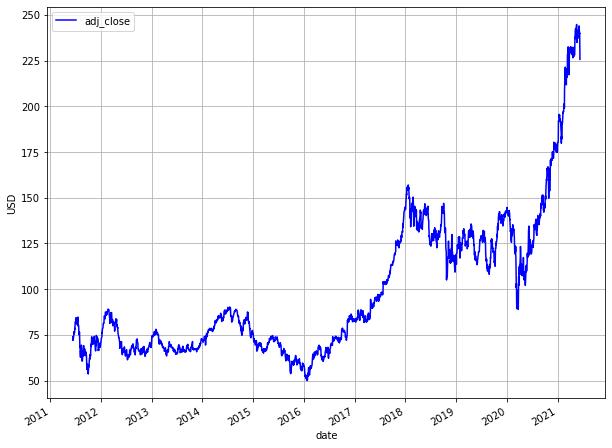

In [161]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [162]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1510
num_cv = 503
num_test = 503
train.shape = (1510, 7)
cv.shape = (503, 7)
train_cv.shape = (2013, 7)
test.shape = (503, 7)


In [163]:
test['date'].min(), test['date'].max()

(Timestamp('2019-06-13 00:00:00'), Timestamp('2021-06-10 00:00:00'))

Text(0, 0.5, 'USD')

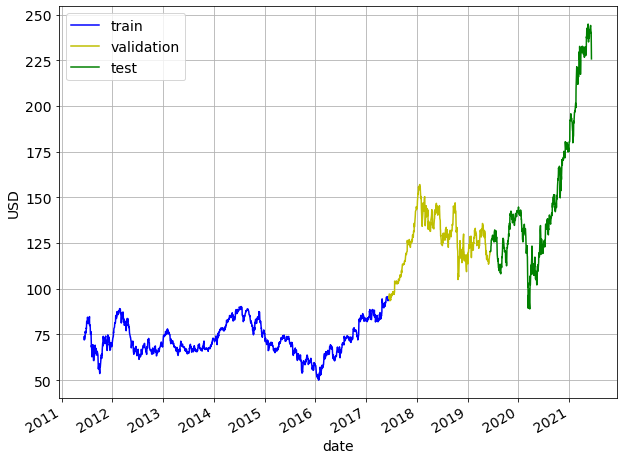

In [164]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [165]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [2.2897799576771285, 2.574354720835569]
MAPE = [1.2798303633558439, 1.4556218247846184]


,date,open,high,low,close,adj_close,volume
0,2011-06-13,96.930000,97.529999,94.720001,95.440002,72.157776,9767400
1,2011-06-14,96.849998,98.449997,96.129997,97.860001,73.987419,8479700
2,2011-06-15,96.580002,97.360001,95.510002,95.650002,72.316536,8143600
3,2011-06-16,95.389999,96.860001,94.209999,95.459999,72.172890,8886500
4,2011-06-17,96.459999,96.940002,95.309998,95.949997,72.543373,8314800


Text(0, 0.5, 'RMSE')

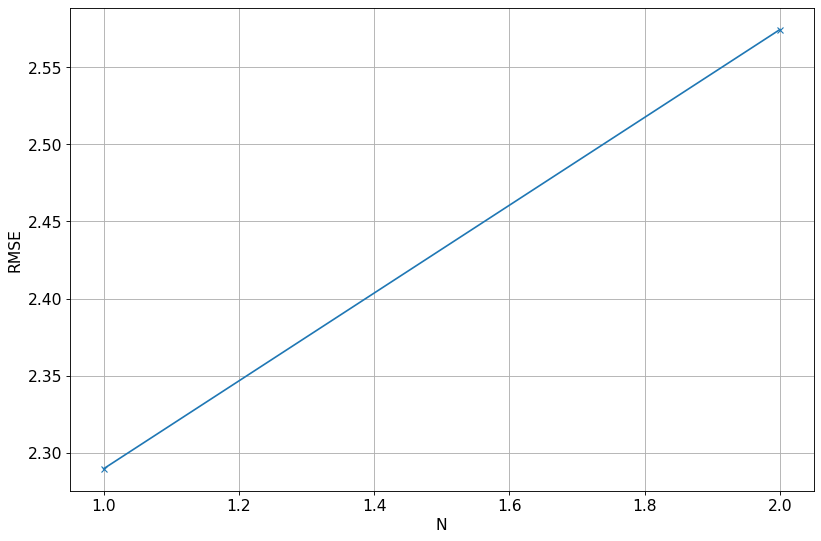

In [166]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE')

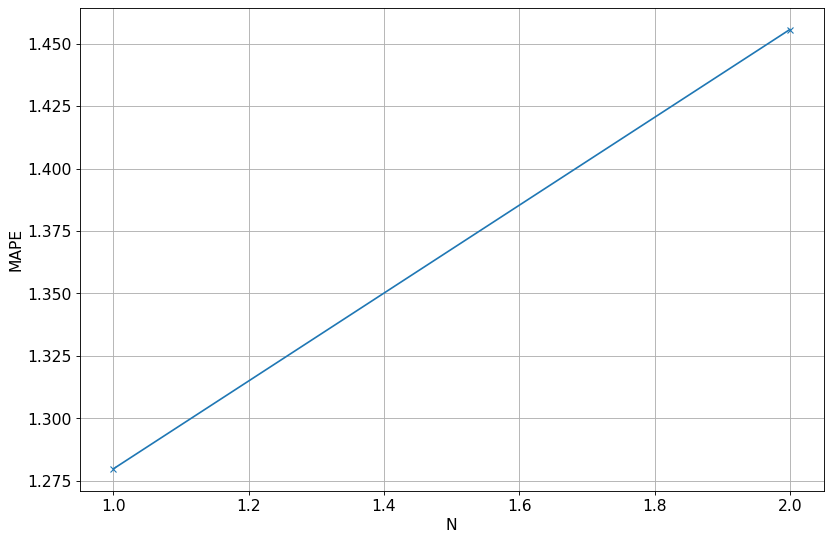

In [167]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [168]:
# Set optimum N
N_opt = 1

Text(0, 0.5, 'USD')

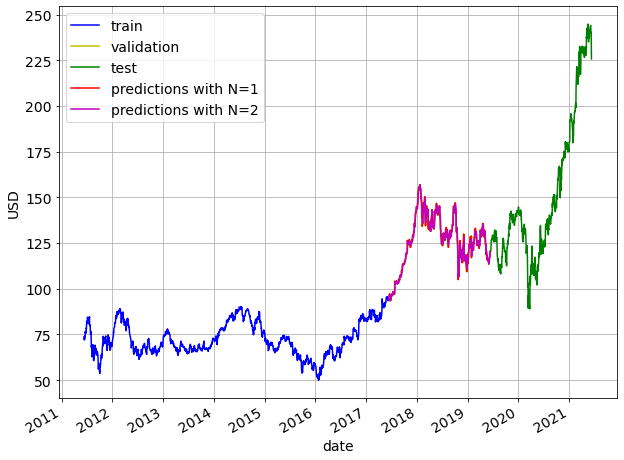

In [169]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

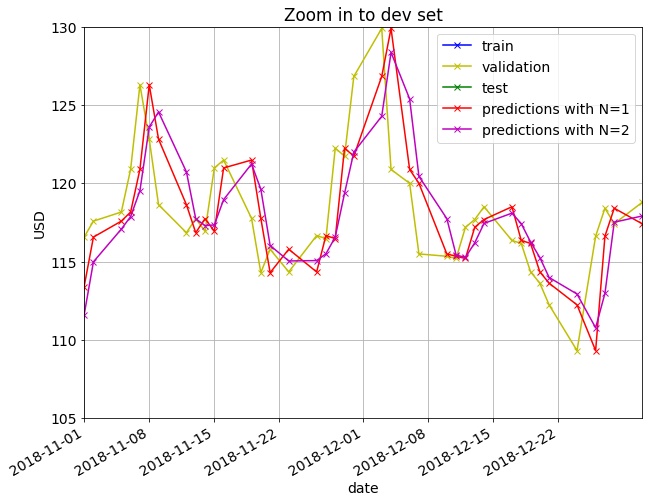

In [170]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 11, 1), date(2018, 12, 31)])
ax.set_ylim([105,130])
ax.set_title('Zoom in to dev set')

In [171]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 3.135
MAPE = 1.602%


,date,open,high,low,close,adj_close,volume,est_N1
2013,2019-06-13,127.349998,128.399994,126.760002,127.169998,120.365616,3495200,120.299362
2014,2019-06-14,126.610001,127.650002,125.500000,127.230003,120.422409,2530100,120.365616
2015,2019-06-17,127.209999,128.229996,126.680000,127.320000,120.507591,2607900,120.422409
2016,2019-06-18,128.399994,131.350006,128.210007,130.330002,123.356537,4756100,120.507591
2017,2019-06-19,130.320007,131.539993,129.869995,130.610001,123.621536,3847200,123.356537


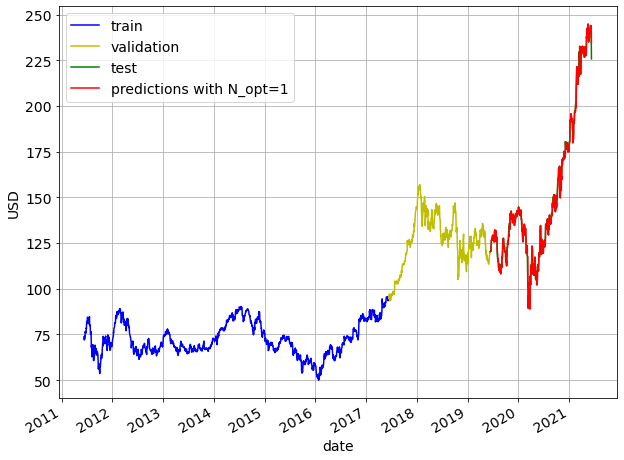

In [172]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
matplotlib.rcParams.update({'font.size': 14})

Text(0.5, 1.0, 'Zoom in to test set')

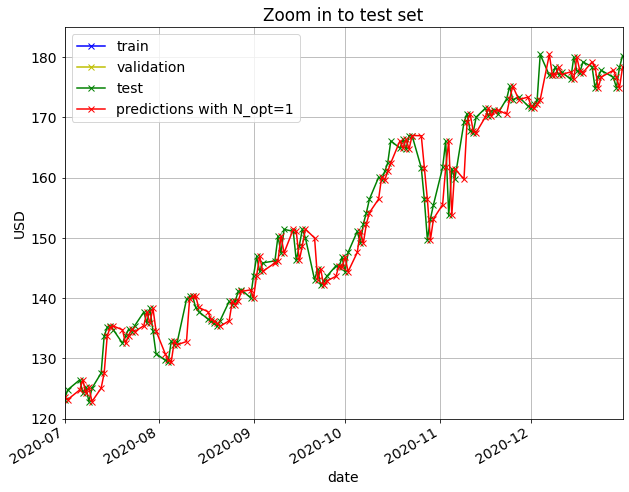

In [173]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 1), date(2020, 12, 31)])
ax.set_ylim([120,185])
ax.set_title('Zoom in to test set')

(120.0, 185.0)

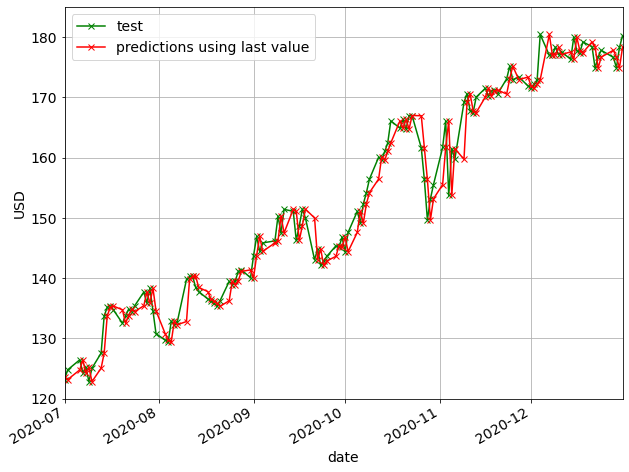

In [174]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using last value'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 7, 1), date(2020, 12, 31)])
ax.set_ylim([120,185])

In [175]:
# Save as csv
test_last_value_CAT = test
test_last_value_CAT.to_csv("C:/Users/Parikshit Ghosh/Downloads/ML models/test_last_value_CAT.csv")